# Exercise 4

**_DISCLAIMER:_** The notation used in this exercise follows the one of the Probabilistic Robotics book (refer to Chapter 5.4 in case you have doubts).

## 4.1 Inverse motion model

The odometry model uses the _relative motion information_. The odometry readings are $u_t = [{\overline{x}}_{t-1} , {\overline{x}}_{t}]$, where $\overline{x}_{t-1}$ and  $\overline{x}_t$ are poses in a robot-internal coordinate frame (different from the map).

The function `inverse_motion_model` takes as input an odometry reading $u_t$ that consist in:

- the initial pose of the robot in the odometry coordinate frame $\overline{x}_{t-1} = [\overline{x},\overline{y},\overline{\theta}]$
- the estimated pose of the robot in the odometry coordinate frame $\overline{x}_t = [\overline{x}',\overline{y}',\overline{\theta}']$

The output is the relative motion $\delta_{rot1}, \delta_{trans}, \delta_{rot2}$.

Implement the function `inverse_motion_model` and verify that it is correct for some test input. **[2.0]**

In [1]:
import numpy as np
def inverse_motion_model(x_t,x_t_1):
    # x_t_1: [x,y,theta]
    # x_t: [x,y]
    # return: [x,y,theta]
    x = x_t[0]
    y = x_t[1]
    x_1 = x_t_1[0]
    y_1 = x_t_1[1]
    delta_x = x - x_1
    delta_y = y - y_1
    theta = np.arctan2(delta_y,delta_x)
    trans = np.sqrt(delta_x**2 + delta_y**2)
    rot1 = theta - x_t_1[2]
    rot2 = x_t[2] - theta
    return [rot1,trans,rot2]

a = [0,0,0]
b = [1,1,0]
print(inverse_motion_model(b,a))

[0.7853981633974483, 1.4142135623730951, -0.7853981633974483]


## 4.2 Odometry-based motion model

The function `motion_model_odometry` computes the posterior $p(x_t | u_t, x_{t-1})$ from odometry readings.

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$ _(**map** coordinate frame)_
- the hypothesized (or query) final pose $x_{t} = [x', y', \theta']$ _(**map** coordinate frame)_
- the odometry readings $u_t = [\overline{x}_{t-1} \overline{x}_t]$ _(**odometry** coordinate frame)_
- the noise parameters $\mathbf{\alpha} = [\alpha_1, \alpha_2, \alpha_3, \alpha_4]$

The output is the probability $p(x_t | u_t, x_{t-1})$

Assume that a robot starts at pose $x_0 = [2.0, 3.0, 0.0]$ in the map frame and moves according to a motion model with $\mathbf{\alpha} = [1.0, 1.0, 0.01, 0.01]$.

The robot excecutes one motion command and the odometry readings are:

1. $\overline{x}_0 = [0.0 , 0.0 , 0.0   ]$
2. $\overline{x}_1 = [0.5 , 0.0 , \pi/2 ]$

Implement the `motion_model_odometry` function and verify that it is correct for some test input. **[1.0]**

---

Consider a 150x150 grid map the world with a resolution of 0.01, centered in the original position of the robot.

Plot the posterior $p(x_t | u_t, x_{t-1})$ for all possible $[x, y]$ values from the grid. **[2.0]**

**Note that** the query input is a position, not a pose. Therefore, to plot the posterior belief over the gridmap, you can assume the term $\hat{\delta}_\mathrm{rot2}$ to be zero and, for each position, integrate over all possible orientations. This can be implemented by considering $p_3 = 1.0$ in the equations. 

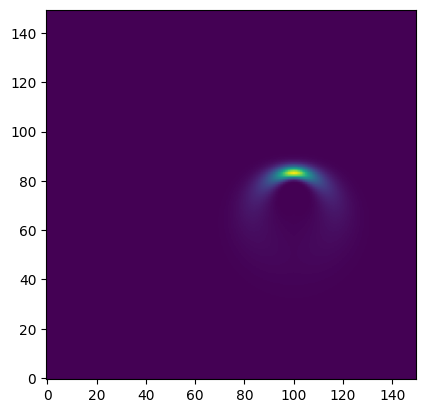

In [2]:
grid_map = np.zeros((150,150))
pose0 = [2.0,3.0,0.0]
odom = [[0.0,0.0,0.0],[0.5,0.0,np.pi/2]]
alpaha = [1.0,1.0,0.01,0.01]
resultion = 0.03
import matplotlib.pyplot as plt

def prob(mu,sigma2):
    return np.exp(-((mu)**2)/(2*sigma2))/np.sqrt(2*np.pi*sigma2)

def motion_model_odometry(x_t,u_t,x_t_1):
    rot1,t,rot2 = inverse_motion_model(u_t[1],u_t[0]) 
    rot1_hat,t_hat,rot2_hat = inverse_motion_model(x_t,x_t_1)
    p1 = prob(rot1-rot1_hat,alpaha[0]*rot1_hat**2+alpaha[1]*t_hat**2)
    p2 = prob(t-t_hat,alpaha[2]*t_hat**2+alpaha[3]*(rot1_hat**2))
    p3 = 1.0
    return p1*p2*p3
for i in range(150):
    for j in range(150):
        grid_map[i,j] = motion_model_odometry([i*resultion,j*resultion,0],odom,pose0)
plt.imshow(grid_map,origin="lower")

## 4.3 Sample odometry motion model

The `motion_model_odometry` requires high computation complexity and does not scale well to large real-world environments. 

One effective approach to approximate $p(x_t | u_t, x_{t-1})$ is to use **sampling**.

The `sample_motion_model_odometry` function defines the sampling-based odometry motion model. 

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$ _(**map** coordinate frame)_
- the odometry readings $u_t = [\overline{x}_{t-1} \overline{x}_t]$ _(**odometry** coordinate frame)_
- the noise parameters $\mathbf{\alpha} = [\alpha_1, \alpha_2, \alpha_3, \alpha_4]$

The output is a new (sampled) pose predicted by the motion model.

Implement the `sample_motion_model_odometry` function and verify that it is correct for some test input. **[2.0]**

In [3]:
def sample_motion_model_odometry(u_t,x_t_1):
    rot1,t,rot2 = inverse_motion_model(u_t[1],u_t[0])
    rot1_hat = rot1 - np.random.normal(0,np.sqrt(alpaha[0]*rot1**2+alpaha[1]*t**2))
    t_hat = t - np.random.normal(0,np.sqrt(alpaha[2]*t**2+alpaha[3]*(rot1**2)))
    rot2_hat = rot2 - np.random.normal(0,np.sqrt(alpaha[0]*rot2**2+alpaha[1]*t**2))
    x_prime = x_t_1[0] + t_hat*np.cos(x_t_1[2]+rot1_hat)
    y_prime = x_t_1[1] + t_hat*np.sin(x_t_1[2]+rot1_hat)
    theta_prime = x_t_1[2] + rot1_hat + rot2_hat
    return [x_prime,y_prime,theta_prime]

sample_motion_model_odometry(odom,pose0)

[2.47819139748803, 2.993619123990185, 0.604452462112274]

## 4.4 Evaluate sample odometry motion model

Assume that a robot starts at pose $x_0 = [2.0, 3.0, 0.0]$ in the map frame and moves according to a motion model with $\mathbf{\alpha} = [0.1, 0.1, 0.01, 0.01]$.

The robot obtains the following odometry readings:

1. $\overline{x}_0 = [0.0 , 0.0 , 0.0   ]$
2. $\overline{x}_1 = [0.5 , 0.0 , \pi/2 ]$
3. $\overline{x}_2 = [0.5 , 0.5 , 0.0   ]$
4. $\overline{x}_3 = [1.0 , 0.5 , 0.0   ]$
5. $\overline{x}_4 = [1.0 , 1.5 , \pi/2 ]$
6. $\overline{x}_5 = [1.0 , 2.5 , \pi/2 ]$

Evaluate the `sample_motion_model_odometry` by considering 1000 samples and plot the resulting positions for each sample in one unique plot. **[3.0]**

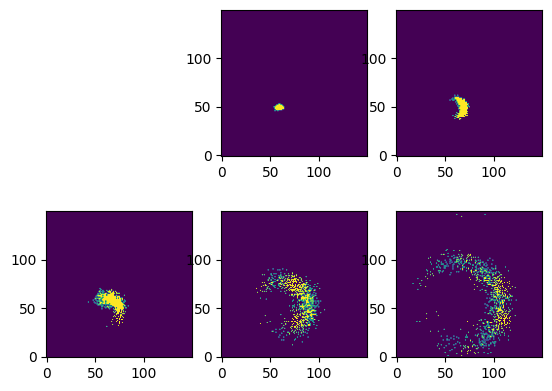

In [5]:
resultion = 0.05
alpaha = [0.1,0.1,0.01,0.01]
odom = [[0.0,0.0,0.0],
        [0.5,0.0,np.pi/2],
        [0.5,0.5,0.0],
        [1.0,0.5,0.0],
        [1.0,1.5,np.pi/2],
        [1.0,2.5,np.pi/2]]
grid_map = np.zeros((150,150))
samples = []
for _ in range(1000):
    samples.append(pose0)
for k in range(5):
    for i,x in enumerate(samples):
        x,y,theta = sample_motion_model_odometry(odom[k:],x)
        samples[i] = [x,y,theta]
    grid_map = np.zeros((150,150))
    for i,(x,y,theta) in enumerate(samples):
        grid_map[int(x/resultion),int(y/resultion)] = 1
    plt.subplot(2,3,k+2)
    plt.imshow(grid_map,origin="lower")